In [1]:
# IMPORTS (INCLUDE)
import numpy as np
import pandas as pd
from tqdm import tqdm
import copy
import os

import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch.utils.data import Dataset, random_split
import torch.optim as optim
from torch_geometric.nn import GATConv, global_add_pool, GCNConv, GINConv
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d as BN
from torch_geometric.explain import Explainer, GNNExplainer

from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import networkx as nx
from PyAstronomy import pyasl
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns

/Users/tancredicogne/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [4]:
np.load("data/preprocessed_data/filtered_nodes/filtered_terminal_disposition_nodes_mad.npy", allow_pickle=True)
# cell membrane is index 6

array(['Adipose tissue', 'Adiposome', 'All tissues', 'Animal', 'Blood',
       'Brain', 'Cell membrane', 'Cerebrospinal fluid', 'Cucurbitaceae',
       'Cytoplasm', 'Endogenous', 'Extracellular', 'Fabaceae', 'Feces',
       'Fibroblast', 'Food', 'Glycine max', 'Hepatic tissue', 'Ingestion',
       'Intracellular membrane', 'Kidney', 'Liver', 'Membrane',
       'Mitochondria', 'Nerve cell', 'Placenta', 'Poaceae', 'Prostate',
       'Saliva', 'Theobroma cacao', 'Urine'], dtype=object)

In [76]:
# CLASS DEF (INCLUDE)
class GraphDataset(Dataset):
    def __init__(self, data_list):
        self.dataset = data_list

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]
    def get_dataset(self):
        return copy.deepcopy(self.dataset)
    
dataset_date = "09_02_24" # TOCHANGE
date = "09_03_24_cell_membrane"#_cell_membrane" # TOCHANGE
level1_node = "disposition" # TOCHANGE
level1_node_num = 1 # TOCHANGE
graph_embedding_length = 600
saving_folder = "model" + "_" + date + "_" + level1_node + "/"
os.makedirs(saving_folder, exist_ok=True)


In [3]:
# STRATIFY (INCLUDE)
def new_stratify(data, idx_dict, ratio):
    test_data = []
    train_data = []
    rest_data = []

    for key, val in idx_dict.items():
        if len(val) >= 10:
            curr_output = [data[v] for v in val.values]
            curr_train, curr_test = random_split(curr_output, ratio)
            train_data += curr_train
            test_data += curr_test
        else:
           rest_data += [data[v] for v in val.values]


    curr_train, curr_test = random_split(rest_data, ratio)
    train_data += curr_train
    test_data += curr_test
    train_to_remove = []
    test_to_remove = []
    
    for t in train_data:
        if t.edge_attr.shape[0] == 1:
            train_to_remove.append(t)
    for t in test_data:
        if t.edge_attr.shape[0] == 1:
            test_to_remove.append(t)

    train_data = [t for t in train_data if t not in train_to_remove]
    test_data = [t for t in test_data if t not in test_to_remove]
    return train_data, test_data

In [6]:
# RANDOM MODEL (DON'T INCLUDE)
dataset = torch.load('data_collab_disposition/dataset.pt')
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
all_f1s= []
all_accs= []
all_ys = np.zeros((len(dataset), level1_node_num))
for idx, d in enumerate(dataset):
    all_ys[idx] = d.y
for i in range(5):
    seed_everything(i)
    torch_ran = torch.randint(2, size=(len(dataset), level1_node_num), device='cpu')
    f1 = f1_score(all_ys, torch_ran.numpy(), average='macro')
    all_f1s.append(f1)
    accuracy = np.mean(np.array(all_ys) == torch_ran.numpy())
    all_accs.append(accuracy)

    """
    
    for i in range(len(dataset)):
        torch_ran = torch.randint(2, size=np.array(dataset[i].y).shape, device='cpu')
        f1 = f1_score(np.array(dataset[i].y), torch_ran.numpy())
        all_f1s.append(f1_score(np.array(dataset[i].y), torch_ran.numpy()))
    """
print(np.mean(np.array(all_f1s)))
print(np.std(np.array(all_f1s)))
print("--------")
print(np.mean(np.array(all_accs)))
print(np.std(np.array(all_accs)))


FileNotFoundError: [Errno 2] No such file or directory: 'data_collab_disposition/dataset.pt'

In [4]:
# SPLIT SETS (INCLUDE)
def split_sets(device='cpu'):
  dataset = torch.load('data/processed_data/processed_data_' + dataset_date + '_' + level1_node +'/dataset.pt')
  for d in dataset:
    x = d.x[:, :3]
    scaler = StandardScaler()
    scaler.fit(x)
    scaled_x = scaler.transform(x)
    d.x[:,:3] = torch.tensor(scaled_x)
  y_true = pd.read_csv('data/processed_data/processed_data_' + dataset_date + '_' + level1_node +'/filtered_outputs.csv').fillna(False)
  df = y_true.drop(['accession'], axis=1)
  df['RowString'] = df.astype(str).agg(','.join, axis=1)
  index_dict = df.groupby('RowString').groups

  dataset_train, dataset_test = new_stratify(dataset, index_dict, [0.9,0.1]) 

  train_ys = [d.y for d in dataset_train]
  train_ys_df = pd.DataFrame(train_ys)
  num_pos = train_ys_df.value_counts().values[0]
  num_neg = len(train_ys_df) - num_pos
  pos_weight = num_neg / num_pos
  pos_weight = torch.tensor([pos_weight], dtype=torch.float, device=device)
  return dataset_train, dataset_test, pos_weight


In [5]:
# SPLIT SETS (INCLUDE)
# this method is used instead of the previous one if we want to interpret the results and thus look only at one output
# if this method is used, everytime the model is created be sure to set the output to 1 instead of the number of nodes in level1node
def specific_split_sets(node_to_keep, node_to_keep_idx, device='cpu'):
  dataset = torch.load('data/processed_data/processed_data_' + dataset_date + '_' + level1_node +'/dataset.pt')
  for d in dataset:
    x = d.x[:, :3]
    scaler = StandardScaler()
    scaler.fit(x)
    scaled_x = scaler.transform(x)
    d.x[:,:3] = torch.tensor(scaled_x)
    
  for d in dataset:
    node_value = d.y[node_to_keep_idx]
    d.y = node_value
  y_true = pd.read_csv('data/processed_data/processed_data_'+ dataset_date + '_' + level1_node +'/filtered_outputs.csv').fillna(False)
  df = y_true.drop(['accession'], axis=1)
  df.filter([node_to_keep])
  df['RowString'] = df.astype(str).agg(','.join, axis=1)
  index_dict = df.groupby('RowString').groups

  dataset_train, dataset_test = new_stratify(dataset, index_dict, [0.9,0.1]) 

  train_ys = [d.y for d in dataset_train]
  train_ys_df = pd.DataFrame(train_ys)
  num_pos = train_ys_df.value_counts().values[0]
  num_neg = len(train_ys_df) - num_pos
  pos_weight = num_neg / num_pos
  pos_weight = torch.tensor([pos_weight], dtype=torch.float, device=device)
  return dataset_train, dataset_test, pos_weight

In [43]:
# GAT MODELS (INCLUDE)
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, heads, output_dim):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, hidden_channels,heads)
        self.fc = torch.nn.Linear(heads*hidden_channels + graph_embedding_length, output_dim) # TOCHANGE

    def forward(self, x, edge_index, batch, edge_weight, graph_embedding):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x.float(), edge_index, edge_weight)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        x = self.conv2(x, edge_index, edge_weight)
        x = global_add_pool(x, batch)
        x = torch.concat([x, torch.tensor(np.array(graph_embedding), dtype=torch.float).squeeze(1)], dim=1) # TOCHANGE
        x = self.fc(x)
        return x
    
class deepGAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, heads, output_dim):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, hidden_channels,heads)
        self.conv3 = GATConv(heads*hidden_channels, hidden_channels,heads)
        self.conv4 = GATConv(heads*hidden_channels, hidden_channels,heads)
        self.fc = torch.nn.Linear(heads*hidden_channels + graph_embedding_length, output_dim) # TOCHANGE

    def forward(self, x, edge_index, batch, edge_weight, graph_embedding):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x.float(), edge_index, edge_weight)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        x = self.conv2(x, edge_index, edge_weight)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        x = self.conv3(x, edge_index, edge_weight)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        x = self.conv4(x, edge_index, edge_weight)
        x = global_add_pool(x, batch)
        x = torch.concat([x, torch.tensor(np.array(graph_embedding), dtype=torch.float).squeeze(1)], dim=1) # TOCHANGE
        x = self.fc(x)
        return x

class GAT_att_weights(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, heads, output_dim):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, hidden_channels,heads)
        self.fc = torch.nn.Linear(heads*hidden_channels, output_dim)

    def forward(self, x, edge_index, batch, edge_weight, graph_embedding):
        x = F.dropout(x, p=0.6, training=self.training)
        x, weights = self.conv1(x, edge_index, edge_weight, return_attention_weights=True)
        weights1_idx, weights1_vals = weights
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)

        x, weights = self.conv2(x, edge_index, edge_weight, return_attention_weights=True)
        weights2_idx, weights2_vals = weights
        x = global_add_pool(x, batch)
        #x = torch.concat([x, torch.tensor(np.array(graph_embedding), dtype=torch.float)], dim=1) # for extra info
        x = self.fc(x)
        return x, weights1_idx, weights1_vals, weights2_idx, weights2_vals


In [11]:
# GIN MODEL (INCLUDE?)
class GIN(torch.nn.Module):
    def __init__(self, num_layers, hidden_dim, num_features, output_dim):
        super(GIN, self).__init__()
        self.conv1 = GINConv(Sequential(
            Linear(num_features, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            BN(hidden_dim)), train_eps=True)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(Sequential(
                    Linear(hidden_dim, hidden_dim),
                    ReLU(),
                    Linear(hidden_dim, hidden_dim),
                    ReLU(),
                    BN(hidden_dim),
                ),
                        train_eps=True))
        self.lin1 = Linear(hidden_dim, hidden_dim)#+graph_embedding_length, hidden_dim)
        self.lin2 = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch, edge_weight, graph_embedding):
        x = self.conv1(x.float(), edge_index)
        for conv in self.convs:
            x = conv(x, edge_index)
        x = global_add_pool(x, batch)
        #x = torch.concat([x, torch.tensor(np.array(graph_embedding), dtype=torch.float).squeeze(1)], dim=1) # TOCHANGE
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.lin2(x)
        return x

In [32]:
# GCN MODEL (INCLUDE?)
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim1, hidden_dim2, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.fc = torch.nn.Linear(hidden_dim2, output_dim)# + graph_embedding_length, output_dim) # TOCHANGE

    def forward(self, x, edge_index, batch, edge_weight, graph_embedding):
        x = torch.relu(self.conv1(x.float(), edge_index, edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight))
        x = global_add_pool(x, batch)
        #x = torch.concat([x, torch.tensor(np.array(graph_embedding), dtype=torch.float).squeeze(1)], dim=1) # TOCHANGE
        x = self.fc(x)
        x = F.dropout(x, p=0.6, training=self.training)
        return x

In [8]:
"""EGNN Implementation from Satorras et al. https://github.com/vgsatorras/egnn"""
import torch.nn as nn


def unsorted_segment_sum(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)


def get_edges(n_nodes):
    rows, cols = [], []
    for i, j in itertools.product(range(n_nodes), range(n_nodes)):
        if i != j:
            rows.append(i)
            cols.append(j)

    return [rows, cols]


def get_edges_batch(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = torch.ones(len(edges[0]) * batch_size, 1)
    edges = [torch.LongTensor(edges[0]), torch.LongTensor(edges[1])]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [torch.cat(rows), torch.cat(cols)]
    return edges, edge_attr

class E_GCL(nn.Module):
    """
    E(n) Equivariant Convolutional Layer
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, act_fn=nn.SiLU(), residual=True, attention=False, normalize=False, coords_agg='mean', tanh=False):
        super(E_GCL, self).__init__()
        input_edge = input_nf * 2
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.coords_agg = coords_agg
        self.tanh = tanh
        self.epsilon = 1e-8
        edge_coords_nf = 1

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        coord_mlp = [nn.Linear(hidden_nf, hidden_nf)]
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh:
            coord_mlp.append(nn.Tanh())
        self.coord_mlp = nn.Sequential(*coord_mlp)

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1)
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        if self.residual:
            out = x + out
        return out, agg

    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        if self.coords_agg == 'sum':
            agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        elif self.coords_agg == 'mean':
            agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        else:
            raise Exception('Wrong coords_agg parameter' % self.coords_agg)
        coord += agg
        return coord

    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff**2, 1).unsqueeze(1)

        if self.normalize:
            norm = torch.sqrt(radial).detach() + self.epsilon
            coord_diff = coord_diff / norm

        return radial, coord_diff

    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)

        return h, coord, edge_attr


In [ ]:
class EGNN(nn.Module):
    def __init__(self, in_node_nf, hidden_nf, out_node_nf, in_edge_nf=0, device='cpu', act_fn=nn.SiLU(), n_layers=4, residual=True, attention=False, normalize=False, tanh=False):
        '''
        :param in_node_nf: Number of features for 'h' at the input
        :param hidden_nf: Number of hidden features
        :param out_node_nf: Number of features for 'h' at the output
        :param in_edge_nf: Number of features for the edge features
        :param device: Device (e.g. 'cpu', 'cuda:0',...)
        :param act_fn: Non-linearity
        :param n_layers: Number of layer for the EGNN
        :param residual: Use residual connections, we recommend not changing this one
        :param attention: Whether using attention or not
        :param normalize: Normalizes the coordinates messages such that:
                    instead of: x^{l+1}_i = x^{l}_i + Σ(x_i - x_j)phi_x(m_ij)
                    we get:     x^{l+1}_i = x^{l}_i + Σ(x_i - x_j)phi_x(m_ij)/||x_i - x_j||
                    We noticed it may help in the stability or generalization in some future works.
                    We didn't use it in our paper.
        :param tanh: Sets a tanh activation function at the output of phi_x(m_ij). I.e. it bounds the output of
                        phi_x(m_ij) which definitely improves in stability but it may decrease in accuracy.
        '''

        super(EGNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        self.embedding_in = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(n_layers):
            self.add_module("gcl_%d" % i, E_GCL(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf,
                                                act_fn=act_fn, residual=residual, attention=attention,
                                                normalize=normalize, tanh=tanh))
        self.to(self.device)

    def forward(self, h, x, edges, edge_attr):
        h = self.embedding_in(h)
        for i in range(self.n_layers):
            h, x, _ = self._modules["gcl_%d" % i](h, edges, x, edge_attr=edge_attr)
        h = self.embedding_out(h)
        return h, x



In [77]:
# TRAIN FUNCTION (INCLUDE, BUT NOT AS CROSS VAL?)
def cat_or_start(all, curr, dim=0):
    if all is None:
        all = curr
    else:
        all = torch.cat((all, curr), dim=dim)
    return all

def train(model, trainloader, validloader, device, criterion, optimizer, threshold, num_epochs):
    model.to(device)

    best_f1_validation = 0.0
    best_epoch = 1
    all_valid_pred = None
    all_valid_true = None
    best_model_wts = copy.deepcopy(model.state_dict())

    train_f1s = []
    train_accs = []
    train_recalls = []
    train_losses = []

    valid_f1s = []
    valid_accs = []
    valid_recalls = []
    valid_losses = []

    with tqdm(total=num_epochs) as pbar:
        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0
            y_pred_train = None
            y_true_train = None
            
            for train_data in trainloader:
                train_data.to(device)
                optimizer.zero_grad()
                outputs = model(train_data.x, train_data.edge_index, train_data.batch, train_data.edge_attr.squeeze(), train_data.graph_embedding)
                curr_true_y = torch.FloatTensor(np.array(train_data.y, 'int8')[:, 6]).unsqueeze(1).to(device) # TO CHANGE
                loss = criterion(outputs, curr_true_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                curr_outputs = outputs.detach().cpu()

                y_true_train = cat_or_start(y_true_train, curr_true_y)
                y_pred_train = cat_or_start(y_pred_train, curr_outputs)

            y_true_train = y_true_train.cpu()
            y_pred_binary_train = torch.where(torch.sigmoid(y_pred_train) < threshold, torch.tensor(0.0), torch.tensor(1.0))
            train_accuracy = np.mean(np.array(y_true_train) == np.array(y_pred_binary_train))
            train_f1 = f1_score(y_true_train, y_pred_binary_train, average="macro")
            train_recall = recall_score(y_true_train, y_pred_binary_train, average="macro")
            train_accs.append(train_accuracy)
            train_f1s.append(train_f1)
            train_recalls.append(train_recall)
            train_losses.append(train_loss / len(trainloader))
    
            pbar.set_description(f'Epoch {epoch+1}      Train: Loss = {train_loss / len(trainloader):.4f}, Recall = {train_recall:.4f}, F1 Score = {train_f1:.4f}')
            pbar.update(1)

            # Validation
            valid_loss = 0.0
            y_true_valid = None
            y_pred_valid = None
            with torch.no_grad():
                model.eval()
                for valid_data in validloader:
                    valid_data.to(device)
                    outputs = model(valid_data.x, valid_data.edge_index, valid_data.batch, valid_data.edge_attr.squeeze(), valid_data.graph_embedding)
                    curr_true_y = torch.FloatTensor(np.array(valid_data.y, 'int8')[:, 6]).unsqueeze(1).to(device) # TO CHANGE

                    loss = criterion(outputs, curr_true_y)
                    valid_loss += loss.item()
                    curr_outputs = outputs.detach().cpu()
                    
                    y_true_valid = cat_or_start(y_true_valid, curr_true_y)
                    y_pred_valid = cat_or_start(y_pred_valid, outputs)

            y_true_valid = y_true_valid.cpu()
            y_pred_binary_valid = torch.where(torch.sigmoid(y_pred_valid) < threshold, torch.tensor(0.0), torch.tensor(1.0))

            valid_accuracy = np.mean(np.array(y_true_valid) == np.array(y_pred_binary_valid))
            valid_f1 = f1_score(y_true_valid, y_pred_binary_valid, average='macro')
            valid_recall = recall_score(y_true_valid, y_pred_binary_valid, average='macro')
            valid_accs.append(valid_accuracy)
            valid_f1s.append(valid_f1)
            valid_recalls.append(valid_recall)
            valid_losses.append(valid_loss / len(validloader))
            print(f'Epoch {epoch+1} Validation: Loss = {valid_loss / len(validloader):.4f}, Recall = {valid_recall:.4f}, F1 Score = {valid_f1:.4f}\n')
            
            if all_valid_pred is None:
                all_valid_pred = y_pred_valid
            else:
                all_valid_pred = np.concatenate((all_valid_pred, y_pred_valid))
            if all_valid_true is None:
                all_valid_true = y_true_valid
            else:
                all_valid_true = np.concatenate((all_valid_true, y_true_valid))

            if valid_f1 > best_f1_validation:
                    best_f1_validation = valid_f1
                    best_epoch = epoch
                    best_model_wts = copy.deepcopy(model.state_dict())

    return best_epoch, best_model_wts, train_recalls, train_f1s, train_losses, valid_recalls, valid_f1s, valid_losses

In [78]:
# TEST FUNCTION (INCLUDE)
import random
def test(model, testloader, device, criterion, threshold):
    test_loss = 0.0
    with torch.no_grad():
        model.eval()
        y_true_test = None
        y_pred_test = None

        for test_data in testloader:
            test_data.to(device)
            outputs = model(test_data.x, test_data.edge_index, test_data.batch, test_data.edge_attr.squeeze(), test_data.graph_embedding)
            curr_true_y = torch.FloatTensor(np.array(test_data.y, 'int8')[:, 6]).unsqueeze(1).to(device) # TO CHANGE
            loss = criterion(outputs, curr_true_y)
            test_loss += loss.item()
            curr_outputs = outputs.detach().cpu()

            y_true_test = cat_or_start(y_true_test, curr_true_y)
            y_pred_test = cat_or_start(y_pred_test, curr_outputs)
    
        y_true_test = y_true_test.cpu()
        y_pred_binary_test = torch.where(torch.sigmoid(y_pred_test) < threshold, torch.tensor(0.0), torch.tensor(1.0))
        test_accuracy = np.mean(np.array(y_true_test) == np.array(y_pred_binary_test))
        test_f1 = f1_score(y_true_test, y_pred_binary_test, average='macro')
        test_recall = recall_score(y_true_test, y_pred_binary_test, average='macro')
        print(f'Test: Loss = {test_loss / len(testloader):.4f}, Recall = {test_recall:.4f}, F1 Score = {test_f1:.4f}')

        return test_recall, test_f1

In [9]:
# AUGMENT DATASET

def rotate_3d(points, axis, angle):
    """
    Rotate a 3D object around a specified axis by a given angle.
    
    Parameters:
    - points (np.ndarray): An Nx3 array of (x, y, z) coordinates.
    - axis (str): The axis to rotate around ('x', 'y', or 'z').
    - angle (float): The angle to rotate by in radians.
    
    Returns:
    - np.ndarray: The rotated Nx3 array of coordinates.
    """
    if axis == 'x':
        rotation_matrix = np.array([
            [1, 0, 0],
            [0, np.cos(angle), -np.sin(angle)],
            [0, np.sin(angle), np.cos(angle)]
        ])
    elif axis == 'y':
        rotation_matrix = np.array([
            [np.cos(angle), 0, np.sin(angle)],
            [0, 1, 0],
            [-np.sin(angle), 0, np.cos(angle)]
        ])
    elif axis == 'z':
        rotation_matrix = np.array([
            [np.cos(angle), -np.sin(angle), 0],
            [np.sin(angle), np.cos(angle), 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    
    # Apply the rotation matrix to each point
    rotated_points = points.dot(rotation_matrix.T)
    
    return rotated_points

def rotate_2d(points, angle):
    """
    Rotate a 2D object by a given angle.
    
    Parameters:
    - points (np.ndarray): An Nx2 array of (x, y) coordinates.
    - angle (float): The angle to rotate by in radians.
    
    Returns:
    - np.ndarray: The rotated Nx2 array of coordinates.
    """
    # Define the 2D rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    
    # Apply the rotation matrix to each point
    rotated_points = points.dot(rotation_matrix.T)
    
    return rotated_points

def augment_metabolite(metabolite, num):
    # metabolite to augment
    # num: number of fold to augment
    angles = np.random.uniform(0, 2 * np.pi, num)
    axis = ['x', 'y', 'z']
    new_metabolites = [metabolite]
    for a in angles:
        rotated_points = rotate_3d(np.array(metabolite.x[:, :3]), axis[np.random.randint(0,3)], a)
        new_x = metabolite.x.clone()
        new_x[:,:3] = torch.tensor(rotated_points)
        new_metabolites.append(Data(x= new_x, edge_index=metabolite.edge_index, edge_attr=metabolite.edge_attr,
                           y=metabolite.y, graph_embedding = metabolite.graph_embedding))
    
    return new_metabolites

In [79]:
# CROSS-VALIDATION (INCLUDE?)
def cross_validation(dataset_train, dataset_test, device, threshold, num_epochs, lr, weight_decay, pos_weight, num_folds):
    skf = KFold(n_splits=num_folds, shuffle=True, random_state=45)

    batch_size = 64
    augmentation_fold = 5
    testloader = DataLoader(dataset_test, batch_size=batch_size)
    
    all_train_accs = np.zeros((num_folds, num_epochs))
    all_train_f1s = np.zeros((num_folds, num_epochs))
    all_train_recalls = np.zeros((num_folds, num_epochs))
    all_train_losses = np.zeros((num_folds, num_epochs))
    all_valid_accs = np.zeros((num_folds, num_epochs))
    all_valid_f1s = np.zeros((num_folds, num_epochs))
    all_valid_recalls = np.zeros((num_folds, num_epochs))
    all_valid_losses = np.zeros((num_folds, num_epochs))
    all_test_accs = []
    all_test_f1s = []
    all_test_recalls = []
    max_f1 = 0
    bestest_model_wts = None

    curr_fold = 0
    # Initialize the model for this run (inside the cross-validation loop)
    for train_index, val_index in skf.split(dataset_train):
          print(f"***************************************************** Fold {curr_fold+1}/{num_folds} *****************************************************")
          #model = GCN(num_node_features=64, hidden_dim1=32, hidden_dim2=32, output_dim=level1_node_num) # TOCHANGE
          #model = GIN(num_features = 64, num_layers=2, hidden_dim=32, output_dim=level1_node_num) # TOCHANGE
          model = GAT(num_features = 63, heads=8, hidden_channels=32, output_dim=level1_node_num) # TOCHANGE
          criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
          criterion.to(device)
          optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

          # Split training set into training and validation sets for each fold
          fold_train_dataset = [dataset_train[i] for i in train_index]
          fold_train_dataset_augmented = []

          # Augment data TODO update if ever removed
          """
          for d in fold_train_dataset:
               augmented_d = augment_metabolite(d, augmentation_fold)
               fold_train_dataset_augmented += augmented_d
          """
          fold_valid_dataset = [dataset_train[i] for i in val_index]
          fold_trainloader = DataLoader(fold_train_dataset, batch_size=batch_size, shuffle=True)
          """
          fold_trainloader_augmented = DataLoader(fold_train_dataset_augmented, batch_size=batch_size, shuffle=True)
          print(len(fold_trainloader))
          print(len(fold_trainloader_augmented))
          """
          fold_validloader = DataLoader(fold_valid_dataset, batch_size=batch_size)

          # Train and evaluate the model for this fold
          results = train(model, fold_trainloader, fold_validloader, device, criterion, optimizer, threshold, num_epochs)
          _, best_model_wts, train_recalls, train_f1s, train_losses, valid_recalls, valid_f1s, valid_losses = results

          #all_train_accs[curr_fold] = train_accs
          all_train_f1s[curr_fold] = train_f1s
          all_train_recalls[curr_fold] = train_recalls
          all_train_losses[curr_fold] = train_losses
          #all_valid_accs[curr_fold] = valid_accs
          all_valid_f1s[curr_fold] = valid_f1s
          all_valid_recalls[curr_fold] = valid_recalls
          all_valid_losses[curr_fold] = valid_losses
          model.load_state_dict(best_model_wts)
          test_recall, test_f1 = test(model, testloader, device, criterion, threshold)
          all_test_recalls.append(test_recall)
          all_test_f1s.append(test_f1)
          if test_f1 > max_f1:
               max_f1 = test_f1
               bestest_model_wts = best_model_wts
          curr_fold+=1

    # Print final cross-validation results
    average_recall = np.mean(all_test_recalls)
    print(f'\nAverage Recall across {num_folds} folds: {average_recall:.3f}')
    recall_std = np.std(np.array(all_test_recalls))
    print(f'\nRecall std across {num_folds} folds: {recall_std:.3f}')
    average_f1 = np.mean(all_test_f1s)
    print(f'\nAverage F1-Score across {num_folds} folds: {average_f1:.3f}')
    f1_std = np.std(np.array(all_test_f1s))
    print(f'\nF1-Score std across {num_folds} folds: {f1_std:.3f}')
    return bestest_model_wts, all_train_recalls, all_train_f1s, all_train_losses, all_valid_recalls, all_valid_f1s, all_valid_losses

In [80]:
# MODEL TRAINING (INCLUDE)
# Hyper-parameters
num_epochs = 20
threshold = 0.5
lr = 0.005
weight_decay=0.001

# Initialize the GCN model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_train, testing_dataset, pos_weight = split_sets(device)

results = cross_validation(dataset_train, testing_dataset, device, threshold, num_epochs,  lr, weight_decay, pos_weight, num_folds=5)
best_model_wts, all_train_recalls, all_train_f1s, all_train_losses, all_valid_recalls, all_valid_f1s, all_valid_losses  = results

***************************************************** Fold 1/5 *****************************************************


Epoch 1      Train: Loss = 1.8973, Recall = 0.5909, F1 Score = 0.5908:   5%|▌         | 1/20 [00:02<00:38,  2.05s/it]

Epoch 1 Validation: Loss = 0.7430, Recall = 0.6401, F1 Score = 0.6618



Epoch 2      Train: Loss = 0.9063, Recall = 0.6685, F1 Score = 0.6929:  10%|█         | 2/20 [00:04<00:38,  2.12s/it]

Epoch 2 Validation: Loss = 0.5195, Recall = 0.7747, F1 Score = 0.8112



Epoch 3      Train: Loss = 0.6736, Recall = 0.6796, F1 Score = 0.7067:  15%|█▌        | 3/20 [00:06<00:36,  2.14s/it]

Epoch 3 Validation: Loss = 0.4957, Recall = 0.7682, F1 Score = 0.8049



Epoch 4      Train: Loss = 0.5513, Recall = 0.6964, F1 Score = 0.7275:  20%|██        | 4/20 [00:08<00:34,  2.14s/it]

Epoch 4 Validation: Loss = 0.4723, Recall = 0.7179, F1 Score = 0.7547



Epoch 5      Train: Loss = 0.5290, Recall = 0.7120, F1 Score = 0.7448:  25%|██▌       | 5/20 [00:10<00:31,  2.12s/it]

Epoch 5 Validation: Loss = 0.4891, Recall = 0.7529, F1 Score = 0.7906



Epoch 6      Train: Loss = 0.4815, Recall = 0.7279, F1 Score = 0.7631:  30%|███       | 6/20 [00:12<00:30,  2.15s/it]

Epoch 6 Validation: Loss = 0.4605, Recall = 0.7233, F1 Score = 0.7599



Epoch 7      Train: Loss = 0.4877, Recall = 0.7327, F1 Score = 0.7672:  35%|███▌      | 7/20 [00:14<00:27,  2.15s/it]

Epoch 7 Validation: Loss = 0.5397, Recall = 0.8537, F1 Score = 0.8815



Epoch 8      Train: Loss = 0.4716, Recall = 0.7410, F1 Score = 0.7769:  40%|████      | 8/20 [00:17<00:25,  2.15s/it]

Epoch 8 Validation: Loss = 0.4520, Recall = 0.7463, F1 Score = 0.7840



Epoch 9      Train: Loss = 0.4777, Recall = 0.7530, F1 Score = 0.7889:  45%|████▌     | 9/20 [00:19<00:23,  2.15s/it]

Epoch 9 Validation: Loss = 0.4562, Recall = 0.7080, F1 Score = 0.7439



Epoch 10      Train: Loss = 0.4549, Recall = 0.7355, F1 Score = 0.7706:  50%|█████     | 10/20 [00:21<00:21,  2.12s/it]

Epoch 10 Validation: Loss = 0.4452, Recall = 0.6981, F1 Score = 0.7327



Epoch 11      Train: Loss = 0.4638, Recall = 0.7639, F1 Score = 0.8003:  55%|█████▌    | 11/20 [00:23<00:19,  2.11s/it]

Epoch 11 Validation: Loss = 0.4413, Recall = 0.6828, F1 Score = 0.7154



Epoch 12      Train: Loss = 0.5751, Recall = 0.7220, F1 Score = 0.7557:  60%|██████    | 12/20 [00:25<00:16,  2.10s/it]

Epoch 12 Validation: Loss = 0.5089, Recall = 0.6325, F1 Score = 0.6518



Epoch 13      Train: Loss = 0.4414, Recall = 0.7748, F1 Score = 0.8114:  65%|██████▌   | 13/20 [00:27<00:14,  2.12s/it]

Epoch 13 Validation: Loss = 0.4526, Recall = 0.7080, F1 Score = 0.7439



Epoch 14      Train: Loss = 0.4210, Recall = 0.7660, F1 Score = 0.8028:  70%|███████   | 14/20 [00:29<00:12,  2.11s/it]

Epoch 14 Validation: Loss = 0.4383, Recall = 0.7792, F1 Score = 0.8164



Epoch 15      Train: Loss = 0.4008, Recall = 0.7859, F1 Score = 0.8230:  75%|███████▌  | 15/20 [00:31<00:10,  2.11s/it]

Epoch 15 Validation: Loss = 0.4406, Recall = 0.7475, F1 Score = 0.7860



Epoch 16      Train: Loss = 0.4104, Recall = 0.7600, F1 Score = 0.7966:  80%|████████  | 16/20 [00:33<00:08,  2.09s/it]

Epoch 16 Validation: Loss = 0.4789, Recall = 0.8614, F1 Score = 0.8890



Epoch 17      Train: Loss = 0.3979, Recall = 0.7876, F1 Score = 0.8242:  85%|████████▌ | 17/20 [00:35<00:06,  2.08s/it]

Epoch 17 Validation: Loss = 0.4558, Recall = 0.7146, F1 Score = 0.7511



Epoch 18      Train: Loss = 0.3987, Recall = 0.7903, F1 Score = 0.8266:  90%|█████████ | 18/20 [00:38<00:04,  2.11s/it]

Epoch 18 Validation: Loss = 0.4536, Recall = 0.7179, F1 Score = 0.7547



Epoch 19      Train: Loss = 0.4073, Recall = 0.7868, F1 Score = 0.8235:  95%|█████████▌| 19/20 [00:40<00:02,  2.10s/it]

Epoch 19 Validation: Loss = 0.4329, Recall = 0.8088, F1 Score = 0.8438



Epoch 20      Train: Loss = 0.4070, Recall = 0.7762, F1 Score = 0.8121: 100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


Epoch 20 Validation: Loss = 0.4468, Recall = 0.7475, F1 Score = 0.7860

Test: Loss = 0.4522, Recall = 0.7921, F1 Score = 0.8259
***************************************************** Fold 2/5 *****************************************************


Epoch 1      Train: Loss = 1.9394, Recall = 0.6127, F1 Score = 0.6201:   5%|▌         | 1/20 [00:01<00:35,  1.89s/it]

Epoch 1 Validation: Loss = 0.7090, Recall = 0.6198, F1 Score = 0.6365



Epoch 2      Train: Loss = 0.6627, Recall = 0.6795, F1 Score = 0.7060:  10%|█         | 2/20 [00:03<00:35,  1.97s/it]

Epoch 2 Validation: Loss = 0.5940, Recall = 0.6780, F1 Score = 0.7108



Epoch 3      Train: Loss = 0.5945, Recall = 0.6762, F1 Score = 0.7022:  15%|█▌        | 3/20 [00:06<00:35,  2.08s/it]

Epoch 3 Validation: Loss = 0.5442, Recall = 0.7454, F1 Score = 0.7837



Epoch 4      Train: Loss = 0.5994, Recall = 0.7054, F1 Score = 0.7364:  20%|██        | 4/20 [00:08<00:32,  2.06s/it]

Epoch 4 Validation: Loss = 0.7341, Recall = 0.6769, F1 Score = 0.7104



Epoch 5      Train: Loss = 0.6253, Recall = 0.7260, F1 Score = 0.7589:  25%|██▌       | 5/20 [00:10<00:32,  2.13s/it]

Epoch 5 Validation: Loss = 0.4728, Recall = 0.7591, F1 Score = 0.8001



Epoch 6      Train: Loss = 0.4903, Recall = 0.7401, F1 Score = 0.7751:  30%|███       | 6/20 [00:12<00:29,  2.11s/it]

Epoch 6 Validation: Loss = 0.4679, Recall = 0.7614, F1 Score = 0.8014



Epoch 7      Train: Loss = 0.4820, Recall = 0.7486, F1 Score = 0.7836:  35%|███▌      | 7/20 [00:14<00:27,  2.09s/it]

Epoch 7 Validation: Loss = 0.4265, Recall = 0.7477, F1 Score = 0.7877



Epoch 8      Train: Loss = 0.4528, Recall = 0.7514, F1 Score = 0.7869:  40%|████      | 8/20 [00:16<00:25,  2.11s/it]

Epoch 8 Validation: Loss = 0.4258, Recall = 0.7420, F1 Score = 0.7827



Epoch 9      Train: Loss = 0.4562, Recall = 0.7565, F1 Score = 0.7925:  45%|████▌     | 9/20 [00:18<00:22,  2.09s/it]

Epoch 9 Validation: Loss = 0.4593, Recall = 0.7442, F1 Score = 0.7842



Epoch 10      Train: Loss = 0.4510, Recall = 0.7849, F1 Score = 0.8203:  50%|█████     | 10/20 [00:20<00:20,  2.08s/it]

Epoch 10 Validation: Loss = 0.4106, Recall = 0.7066, F1 Score = 0.7441



Epoch 11      Train: Loss = 0.4201, Recall = 0.7553, F1 Score = 0.7914:  55%|█████▌    | 11/20 [00:22<00:18,  2.08s/it]

Epoch 11 Validation: Loss = 0.5750, Recall = 0.8755, F1 Score = 0.8997



Epoch 12      Train: Loss = 0.4410, Recall = 0.7834, F1 Score = 0.8188:  60%|██████    | 12/20 [00:24<00:16,  2.07s/it]

Epoch 12 Validation: Loss = 0.4158, Recall = 0.7317, F1 Score = 0.7720



Epoch 13      Train: Loss = 0.4014, Recall = 0.7661, F1 Score = 0.8017:  65%|██████▌   | 13/20 [00:27<00:14,  2.11s/it]

Epoch 13 Validation: Loss = 0.4679, Recall = 0.8173, F1 Score = 0.8513



Epoch 14      Train: Loss = 0.4024, Recall = 0.7959, F1 Score = 0.8316:  70%|███████   | 14/20 [00:29<00:12,  2.08s/it]

Epoch 14 Validation: Loss = 0.4346, Recall = 0.7945, F1 Score = 0.8319



Epoch 15      Train: Loss = 0.3962, Recall = 0.7889, F1 Score = 0.8246:  75%|███████▌  | 15/20 [00:31<00:10,  2.10s/it]

Epoch 15 Validation: Loss = 0.4018, Recall = 0.7694, F1 Score = 0.8102



Epoch 16      Train: Loss = 0.3955, Recall = 0.8066, F1 Score = 0.8412:  80%|████████  | 16/20 [00:33<00:08,  2.09s/it]

Epoch 16 Validation: Loss = 0.3986, Recall = 0.7351, F1 Score = 0.7756



Epoch 17      Train: Loss = 0.4062, Recall = 0.7636, F1 Score = 0.7999:  85%|████████▌ | 17/20 [00:35<00:06,  2.07s/it]

Epoch 17 Validation: Loss = 0.4130, Recall = 0.7853, F1 Score = 0.8245



Epoch 18      Train: Loss = 0.3851, Recall = 0.8060, F1 Score = 0.8402:  90%|█████████ | 18/20 [00:37<00:04,  2.11s/it]

Epoch 18 Validation: Loss = 0.3977, Recall = 0.7385, F1 Score = 0.7792



Epoch 19      Train: Loss = 0.3948, Recall = 0.7774, F1 Score = 0.8139:  95%|█████████▌| 19/20 [00:39<00:02,  2.09s/it]

Epoch 19 Validation: Loss = 0.4204, Recall = 0.7990, F1 Score = 0.8371



Epoch 20      Train: Loss = 0.3971, Recall = 0.7988, F1 Score = 0.8337: 100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


Epoch 20 Validation: Loss = 0.4153, Recall = 0.7705, F1 Score = 0.8093

Test: Loss = 0.4926, Recall = 0.8196, F1 Score = 0.8517
***************************************************** Fold 3/5 *****************************************************


Epoch 1      Train: Loss = 1.8113, Recall = 0.5894, F1 Score = 0.5895:   5%|▌         | 1/20 [00:01<00:34,  1.84s/it]

Epoch 1 Validation: Loss = 0.4897, Recall = 0.7079, F1 Score = 0.7412



Epoch 2      Train: Loss = 0.9101, Recall = 0.6497, F1 Score = 0.6702:  10%|█         | 2/20 [00:04<00:37,  2.07s/it]

Epoch 2 Validation: Loss = 0.8205, Recall = 0.5764, F1 Score = 0.5618



Epoch 3      Train: Loss = 0.6693, Recall = 0.6762, F1 Score = 0.7037:  15%|█▌        | 3/20 [00:06<00:34,  2.05s/it]

Epoch 3 Validation: Loss = 0.4835, Recall = 0.6600, F1 Score = 0.6825



Epoch 4      Train: Loss = 0.5405, Recall = 0.6743, F1 Score = 0.7019:  20%|██        | 4/20 [00:08<00:32,  2.05s/it]

Epoch 4 Validation: Loss = 0.4534, Recall = 0.7273, F1 Score = 0.7608



Epoch 5      Train: Loss = 0.5610, Recall = 0.7070, F1 Score = 0.7399:  25%|██▌       | 5/20 [00:10<00:30,  2.06s/it]

Epoch 5 Validation: Loss = 0.4401, Recall = 0.7819, F1 Score = 0.8166



Epoch 6      Train: Loss = 0.4680, Recall = 0.7203, F1 Score = 0.7552:  30%|███       | 6/20 [00:12<00:29,  2.07s/it]

Epoch 6 Validation: Loss = 0.4544, Recall = 0.6903, F1 Score = 0.7198



Epoch 7      Train: Loss = 0.4661, Recall = 0.7358, F1 Score = 0.7719:  35%|███▌      | 7/20 [00:14<00:27,  2.12s/it]

Epoch 7 Validation: Loss = 0.4463, Recall = 0.7061, F1 Score = 0.7373



Epoch 8      Train: Loss = 0.4454, Recall = 0.7342, F1 Score = 0.7710:  40%|████      | 8/20 [00:16<00:25,  2.10s/it]

Epoch 8 Validation: Loss = 0.4564, Recall = 0.7043, F1 Score = 0.7357



Epoch 9      Train: Loss = 0.4554, Recall = 0.7425, F1 Score = 0.7794:  45%|████▌     | 9/20 [00:18<00:23,  2.10s/it]

Epoch 9 Validation: Loss = 0.4513, Recall = 0.7588, F1 Score = 0.7945



Epoch 10      Train: Loss = 0.4309, Recall = 0.7467, F1 Score = 0.7840:  50%|█████     | 10/20 [00:20<00:20,  2.09s/it]

Epoch 10 Validation: Loss = 0.4533, Recall = 0.7073, F1 Score = 0.7391



Epoch 11      Train: Loss = 0.4120, Recall = 0.7634, F1 Score = 0.8010:  55%|█████▌    | 11/20 [00:22<00:18,  2.08s/it]

Epoch 11 Validation: Loss = 0.4999, Recall = 0.6521, F1 Score = 0.6724



Epoch 12      Train: Loss = 0.4220, Recall = 0.7453, F1 Score = 0.7822:  60%|██████    | 12/20 [00:25<00:16,  2.11s/it]

Epoch 12 Validation: Loss = 0.4452, Recall = 0.7649, F1 Score = 0.8006



Epoch 13      Train: Loss = 0.3957, Recall = 0.7798, F1 Score = 0.8178:  65%|██████▌   | 13/20 [00:27<00:14,  2.10s/it]

Epoch 13 Validation: Loss = 0.4642, Recall = 0.7073, F1 Score = 0.7391



Epoch 14      Train: Loss = 0.4252, Recall = 0.7664, F1 Score = 0.8043:  70%|███████   | 14/20 [00:29<00:12,  2.09s/it]

Epoch 14 Validation: Loss = 0.4540, Recall = 0.7970, F1 Score = 0.8310



Epoch 15      Train: Loss = 0.4022, Recall = 0.7826, F1 Score = 0.8203:  75%|███████▌  | 15/20 [00:31<00:10,  2.07s/it]

Epoch 15 Validation: Loss = 0.4921, Recall = 0.6903, F1 Score = 0.7198



Epoch 16      Train: Loss = 0.3996, Recall = 0.7828, F1 Score = 0.8201:  80%|████████  | 16/20 [00:33<00:08,  2.07s/it]

Epoch 16 Validation: Loss = 0.4591, Recall = 0.7770, F1 Score = 0.8126



Epoch 17      Train: Loss = 0.3818, Recall = 0.7839, F1 Score = 0.8213:  85%|████████▌ | 17/20 [00:35<00:06,  2.12s/it]

Epoch 17 Validation: Loss = 0.4662, Recall = 0.7285, F1 Score = 0.7627



Epoch 18      Train: Loss = 0.3826, Recall = 0.7873, F1 Score = 0.8248:  90%|█████████ | 18/20 [00:37<00:04,  2.10s/it]

Epoch 18 Validation: Loss = 0.4638, Recall = 0.7982, F1 Score = 0.8330



Epoch 19      Train: Loss = 0.3704, Recall = 0.7780, F1 Score = 0.8158:  95%|█████████▌| 19/20 [00:39<00:02,  2.14s/it]

Epoch 19 Validation: Loss = 0.4606, Recall = 0.8340, F1 Score = 0.8628



Epoch 20      Train: Loss = 0.3613, Recall = 0.7970, F1 Score = 0.8339: 100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


Epoch 20 Validation: Loss = 0.4557, Recall = 0.8110, F1 Score = 0.8431

Test: Loss = 0.4298, Recall = 0.7811, F1 Score = 0.8153
***************************************************** Fold 4/5 *****************************************************


Epoch 1      Train: Loss = 2.4175, Recall = 0.6221, F1 Score = 0.6343:   5%|▌         | 1/20 [00:02<00:46,  2.44s/it]

Epoch 1 Validation: Loss = 0.8703, Recall = 0.7681, F1 Score = 0.7939



Epoch 2      Train: Loss = 0.8248, Recall = 0.6570, F1 Score = 0.6800:  10%|█         | 2/20 [00:04<00:44,  2.47s/it]

Epoch 2 Validation: Loss = 0.8278, Recall = 0.5595, F1 Score = 0.5303



Epoch 3      Train: Loss = 0.5995, Recall = 0.6557, F1 Score = 0.6786:  15%|█▌        | 3/20 [00:07<00:41,  2.43s/it]

Epoch 3 Validation: Loss = 0.5024, Recall = 0.6958, F1 Score = 0.7251



Epoch 4      Train: Loss = 0.5537, Recall = 0.6745, F1 Score = 0.7024:  20%|██        | 4/20 [00:10<00:41,  2.58s/it]

Epoch 4 Validation: Loss = 0.5543, Recall = 0.7677, F1 Score = 0.8019



Epoch 5      Train: Loss = 0.5228, Recall = 0.7101, F1 Score = 0.7429:  25%|██▌       | 5/20 [00:12<00:39,  2.63s/it]

Epoch 5 Validation: Loss = 0.5174, Recall = 0.6655, F1 Score = 0.6885



Epoch 6      Train: Loss = 0.4845, Recall = 0.7033, F1 Score = 0.7360:  30%|███       | 6/20 [00:15<00:36,  2.60s/it]

Epoch 6 Validation: Loss = 0.5055, Recall = 0.7267, F1 Score = 0.7608



Epoch 7      Train: Loss = 0.4911, Recall = 0.7060, F1 Score = 0.7391:  35%|███▌      | 7/20 [00:17<00:31,  2.44s/it]

Epoch 7 Validation: Loss = 0.5168, Recall = 0.8255, F1 Score = 0.8574



Epoch 8      Train: Loss = 0.4874, Recall = 0.7506, F1 Score = 0.7875:  40%|████      | 8/20 [00:19<00:27,  2.33s/it]

Epoch 8 Validation: Loss = 0.5642, Recall = 0.6761, F1 Score = 0.7017



Epoch 9      Train: Loss = 0.4750, Recall = 0.7375, F1 Score = 0.7743:  45%|████▌     | 9/20 [00:21<00:24,  2.26s/it]

Epoch 9 Validation: Loss = 0.4925, Recall = 0.6922, F1 Score = 0.7216



Epoch 10      Train: Loss = 0.4423, Recall = 0.7294, F1 Score = 0.7655:  50%|█████     | 10/20 [00:23<00:22,  2.23s/it]

Epoch 10 Validation: Loss = 0.4770, Recall = 0.7488, F1 Score = 0.7852



Epoch 11      Train: Loss = 0.4555, Recall = 0.7604, F1 Score = 0.7973:  55%|█████▌    | 11/20 [00:25<00:19,  2.17s/it]

Epoch 11 Validation: Loss = 0.4939, Recall = 0.8499, F1 Score = 0.8770



Epoch 12      Train: Loss = 0.4512, Recall = 0.7553, F1 Score = 0.7923:  60%|██████    | 12/20 [00:28<00:17,  2.15s/it]

Epoch 12 Validation: Loss = 0.4194, Recall = 0.7833, F1 Score = 0.8195



Epoch 13      Train: Loss = 0.4266, Recall = 0.7607, F1 Score = 0.7978:  65%|██████▌   | 13/20 [00:30<00:14,  2.13s/it]

Epoch 13 Validation: Loss = 0.4663, Recall = 0.7464, F1 Score = 0.7813



Epoch 14      Train: Loss = 0.4120, Recall = 0.7594, F1 Score = 0.7968:  70%|███████   | 14/20 [00:32<00:13,  2.19s/it]

Epoch 14 Validation: Loss = 0.4540, Recall = 0.8166, F1 Score = 0.8494



Epoch 15      Train: Loss = 0.4394, Recall = 0.7677, F1 Score = 0.8048:  75%|███████▌  | 15/20 [00:34<00:10,  2.16s/it]

Epoch 15 Validation: Loss = 0.4754, Recall = 0.7238, F1 Score = 0.7575



Epoch 16      Train: Loss = 0.4295, Recall = 0.7867, F1 Score = 0.8226:  80%|████████  | 16/20 [00:36<00:08,  2.16s/it]

Epoch 16 Validation: Loss = 0.5165, Recall = 0.6446, F1 Score = 0.6611



Epoch 17      Train: Loss = 0.4945, Recall = 0.7383, F1 Score = 0.7752:  85%|████████▌ | 17/20 [00:38<00:06,  2.14s/it]

Epoch 17 Validation: Loss = 0.4516, Recall = 0.8445, F1 Score = 0.8704



Epoch 18      Train: Loss = 0.4283, Recall = 0.7845, F1 Score = 0.8211:  90%|█████████ | 18/20 [00:40<00:04,  2.12s/it]

Epoch 18 Validation: Loss = 0.4354, Recall = 0.7101, F1 Score = 0.7426



Epoch 19      Train: Loss = 0.4015, Recall = 0.7824, F1 Score = 0.8186:  95%|█████████▌| 19/20 [00:43<00:02,  2.16s/it]

Epoch 19 Validation: Loss = 0.4313, Recall = 0.7731, F1 Score = 0.8087



Epoch 20      Train: Loss = 0.4271, Recall = 0.7820, F1 Score = 0.8191: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Epoch 20 Validation: Loss = 0.4978, Recall = 0.6684, F1 Score = 0.6923

Test: Loss = 0.4621, Recall = 0.7944, F1 Score = 0.8296
***************************************************** Fold 5/5 *****************************************************


Epoch 1      Train: Loss = 1.7530, Recall = 0.5988, F1 Score = 0.6039:   5%|▌         | 1/20 [00:02<00:40,  2.14s/it]

Epoch 1 Validation: Loss = 0.6353, Recall = 0.7592, F1 Score = 0.7892



Epoch 2      Train: Loss = 0.7432, Recall = 0.6475, F1 Score = 0.6690:  10%|█         | 2/20 [00:04<00:38,  2.16s/it]

Epoch 2 Validation: Loss = 0.5267, Recall = 0.6281, F1 Score = 0.6327



Epoch 3      Train: Loss = 0.5678, Recall = 0.6732, F1 Score = 0.7019:  15%|█▌        | 3/20 [00:06<00:36,  2.14s/it]

Epoch 3 Validation: Loss = 0.6609, Recall = 0.8017, F1 Score = 0.8269



Epoch 4      Train: Loss = 0.5890, Recall = 0.7113, F1 Score = 0.7460:  20%|██        | 4/20 [00:08<00:34,  2.18s/it]

Epoch 4 Validation: Loss = 0.4956, Recall = 0.7561, F1 Score = 0.7871



Epoch 5      Train: Loss = 0.5338, Recall = 0.7114, F1 Score = 0.7466:  25%|██▌       | 5/20 [00:10<00:32,  2.15s/it]

Epoch 5 Validation: Loss = 0.5039, Recall = 0.6768, F1 Score = 0.6974



Epoch 6      Train: Loss = 0.4859, Recall = 0.7259, F1 Score = 0.7622:  30%|███       | 6/20 [00:13<00:30,  2.20s/it]

Epoch 6 Validation: Loss = 0.4635, Recall = 0.7647, F1 Score = 0.7948



Epoch 7      Train: Loss = 0.4722, Recall = 0.7236, F1 Score = 0.7602:  35%|███▌      | 7/20 [00:15<00:28,  2.16s/it]

Epoch 7 Validation: Loss = 0.4671, Recall = 0.8067, F1 Score = 0.8344



Epoch 8      Train: Loss = 0.4699, Recall = 0.7346, F1 Score = 0.7715:  40%|████      | 8/20 [00:17<00:26,  2.18s/it]

Epoch 8 Validation: Loss = 0.4406, Recall = 0.7574, F1 Score = 0.7890



Epoch 9      Train: Loss = 0.4724, Recall = 0.7385, F1 Score = 0.7757:  45%|████▌     | 9/20 [00:19<00:23,  2.16s/it]

Epoch 9 Validation: Loss = 0.4456, Recall = 0.7453, F1 Score = 0.7747



Epoch 10      Train: Loss = 0.4424, Recall = 0.7519, F1 Score = 0.7890:  50%|█████     | 10/20 [00:21<00:21,  2.16s/it]

Epoch 10 Validation: Loss = 0.4165, Recall = 0.7644, F1 Score = 0.7957



Epoch 11      Train: Loss = 0.4504, Recall = 0.7325, F1 Score = 0.7695:  55%|█████▌    | 11/20 [00:23<00:19,  2.19s/it]

Epoch 11 Validation: Loss = 0.4247, Recall = 0.7478, F1 Score = 0.7784



Epoch 12      Train: Loss = 0.4240, Recall = 0.7553, F1 Score = 0.7936:  60%|██████    | 12/20 [00:26<00:17,  2.18s/it]

Epoch 12 Validation: Loss = 0.3955, Recall = 0.7626, F1 Score = 0.7956



Epoch 13      Train: Loss = 0.4277, Recall = 0.7661, F1 Score = 0.8043:  65%|██████▌   | 13/20 [00:28<00:15,  2.22s/it]

Epoch 13 Validation: Loss = 0.4222, Recall = 0.7083, F1 Score = 0.7361



Epoch 14      Train: Loss = 0.4206, Recall = 0.7604, F1 Score = 0.7980:  70%|███████   | 14/20 [00:30<00:13,  2.18s/it]

Epoch 14 Validation: Loss = 0.3918, Recall = 0.7278, F1 Score = 0.7584



Epoch 15      Train: Loss = 0.4153, Recall = 0.7779, F1 Score = 0.8160:  75%|███████▌  | 15/20 [00:32<00:10,  2.15s/it]

Epoch 15 Validation: Loss = 0.4005, Recall = 0.7417, F1 Score = 0.7738



Epoch 16      Train: Loss = 0.4018, Recall = 0.7791, F1 Score = 0.8180:  80%|████████  | 16/20 [00:34<00:08,  2.15s/it]

Epoch 16 Validation: Loss = 0.4285, Recall = 0.7194, F1 Score = 0.7490



Epoch 17      Train: Loss = 0.4188, Recall = 0.7677, F1 Score = 0.8066:  85%|████████▌ | 17/20 [00:37<00:06,  2.29s/it]

Epoch 17 Validation: Loss = 0.5529, Recall = 0.9038, F1 Score = 0.9100



Epoch 18      Train: Loss = 0.4088, Recall = 0.7898, F1 Score = 0.8274:  90%|█████████ | 18/20 [00:39<00:04,  2.35s/it]

Epoch 18 Validation: Loss = 0.3995, Recall = 0.8261, F1 Score = 0.8522



Epoch 19      Train: Loss = 0.4282, Recall = 0.7679, F1 Score = 0.8063:  95%|█████████▌| 19/20 [00:42<00:02,  2.36s/it]

Epoch 19 Validation: Loss = 0.3875, Recall = 0.7682, F1 Score = 0.8013



Epoch 20      Train: Loss = 0.4203, Recall = 0.7840, F1 Score = 0.8216: 100%|██████████| 20/20 [00:44<00:00,  2.24s/it]

Epoch 20 Validation: Loss = 0.4093, Recall = 0.7644, F1 Score = 0.7957

Test: Loss = 0.4764, Recall = 0.8731, F1 Score = 0.8929

Average Recall across 5 folds: 0.812

Recall std across 5 folds: 0.033

Average F1-Score across 5 folds: 0.843

F1-Score std across 5 folds: 0.028


In [81]:
# COMPARE TWO GRAPHS (DON'T INCLUDE)
def is_same_graph(graph1, graph2):
    x_eq = torch.equal(graph1.x, graph2.x)
    y_eq = np.all(np.array(graph1.y)==np.array(graph2.y))
    graph_embedding_eq = graph1.graph_embedding[0] == graph2.graph_embedding[0]
    return x_eq and y_eq and graph_embedding_eq.all()
test_idx = []
dataset = torch.load('data/processed_data/processed_data_' + dataset_date + '_' + level1_node +'/dataset.pt')
for d in dataset:
    x = d.x[:, :2]
    scaler = StandardScaler()
    scaler.fit(x)
    scaled_x = scaler.transform(x)
    d.x[:,:2] = torch.tensor(scaled_x)
for idx, d in enumerate(dataset):
    for td in testing_dataset:
        if is_same_graph(td, d):
            test_idx.append(idx)

In [82]:
# SAVE BEST MODEL WEIGHTS AND TEST IDX (INCLUDE)
torch.save(best_model_wts, saving_folder +"best_model_wts.pt")
np.save(saving_folder + "test_idx.npy", np.array(test_idx))

In [16]:
# PLOT METRIC (INCLUDE)
def plot_metric(train_values, valid_values, metric_name, log=False):
    mean_train_values = np.mean(train_values, axis=0)
    std_train_values = np.std(train_values, axis=0)

    mean_val_values = np.mean(valid_values, axis=0)
    std_val_values = np.std(valid_values, axis=0)

    epochs = np.arange(1, len(mean_train_values) + 1)
    plt.errorbar(epochs, mean_train_values, yerr=std_train_values, label='Training', capsize=3)
    plt.errorbar(epochs, mean_val_values, yerr=std_val_values, label='Validation', capsize=3)
    plt.xlabel('Epochs')
    plt.xticks(range(0, len(mean_train_values) + 1, 5))
    if log:
        plt.yscale('log')
        plt.ylabel(f'{metric_name} (log-scale)')
    else:
        plt.ylabel(metric_name)
    #plt.title(f'{metric_name} for quantified metabolites on "{level1_node}" terminal nodes')
    plt.legend()
    plt.savefig(saving_folder + f"evolution_{metric_name.lower()}")

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric(train_values, valid_values, metric_name, log=False):
    mean_train_values = np.mean(train_values, axis=0)
    std_train_values = np.std(train_values, axis=0)
    mean_val_values = np.mean(valid_values, axis=0)
    std_val_values = np.std(valid_values, axis=0)
    palette = sns.color_palette("mako_r", 2)
    epochs = np.arange(1, len(mean_train_values) + 1)

    plt.figure(figsize=(10, 6))

    sns.lineplot(x=np.concatenate([epochs, epochs]),
                 y=np.concatenate([mean_train_values, mean_val_values]),
                 hue=['Training'] * len(mean_train_values) + ['Validation'] * len(mean_val_values),
                 palette = palette,
                 errorbar='sd')

    plt.xlabel('Epochs')
    plt.xticks(range(0, len(mean_train_values) + 1, 5))
    plt.grid(True, linestyle='--', alpha=0.7)
    if log:
        plt.yscale('log')
        plt.ylabel(f'{metric_name} (log-scale)')
    else:
        plt.ylabel(metric_name)

    plt.legend()
    plt.savefig(saving_folder + f"evolution_{metric_name.lower()}")


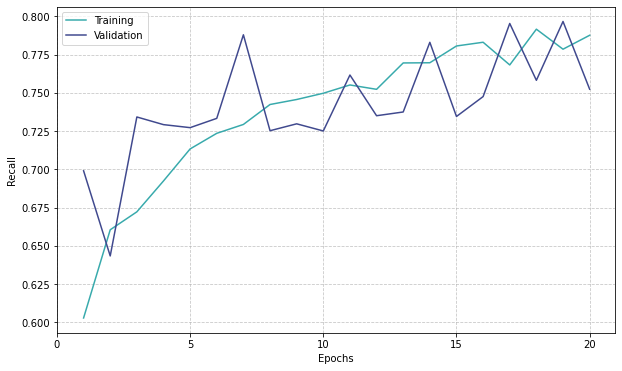

In [83]:
plot_metric(all_train_recalls, all_valid_recalls, "Recall", log=False)

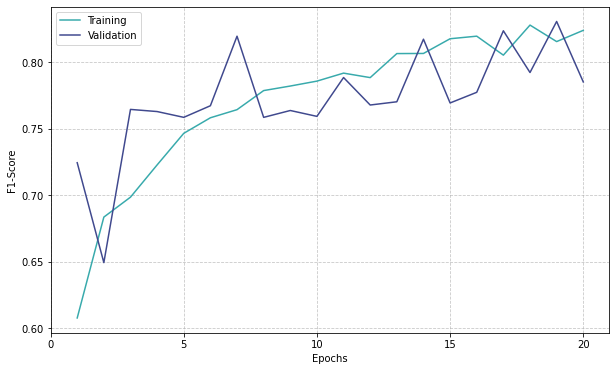

In [84]:
plot_metric(all_train_f1s, all_valid_f1s, "F1-Score", log=False)

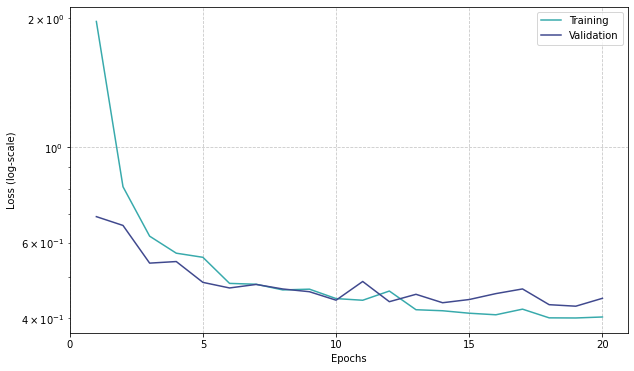

In [85]:
plot_metric(all_train_losses, all_valid_losses, "Loss", log=True)